<a href="https://colab.research.google.com/github/felipecacique/Pytorch-Tutorial-Youtube/blob/main/notebook220f4b13ea.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'animal-image-dataset-90-different-animals:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1554380%2F3952946%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240429%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240429T163254Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D34d87b5599094cfa30424046acf2ff715386b8193d06db9685a4854c1c909657a8d2dbdf19148e3642bfa50c3c61c34400c1930e5a97e3dd61d443f27b7248987cbfabbe4b4ec481ce15504abb9c51f1c3f3f52be047dd734a227107bcf9c70a9e753625c018249e2bf44cf7b35d7d23c0d8f970af033306610907c4071bf7df2c6a5075264d88cf797d9833e196c971cfc4c8fcd7f4c3a39228d119910d1e2e4ea36b0264b8664ef42eb4751f107a45db29aa242a743b61ccc515883cc8495d00cffc2e5786166046505cd96f6c3fc0249132406089a65fb38836c085d8fbeb743411e5a354c5ba93756b4b44662032f7ca44166111d14d70971b0b7e4d352e'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 687914671 bytes downloaded
Downloaded and uncompressed: animal-image-dataset-90-different-animals
Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [28]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import classification_report, f1_score, confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
%matplotlib inline

Loading Dataset

In [8]:
# Loading Dataset
path = "/kaggle/input/animal-image-dataset-90-different-animals/animals/animals"

data = {"imgpath": [], "labels": []}

category = os.listdir(path)
for folder in category:
  folderpath = os.path.join(path, folder)
  filelist = os.listdir(folderpath)
  for file in filelist:
    fpath = os.path.join(folderpath, file)
    data["imgpath"].append(fpath)
    data["labels"].append(folder)

df = pd.DataFrame(data)


,imgpath,labels
0,/kaggle/input/animal-image-dataset-90-differen...,dolphin
1,/kaggle/input/animal-image-dataset-90-differen...,dolphin
2,/kaggle/input/animal-image-dataset-90-differen...,dolphin
3,/kaggle/input/animal-image-dataset-90-differen...,dolphin
4,/kaggle/input/animal-image-dataset-90-differen...,dolphin
...,...,...
5395,/kaggle/input/animal-image-dataset-90-differen...,seahorse
5396,/kaggle/input/animal-image-dataset-90-differen...,seahorse
5397,/kaggle/input/animal-image-dataset-90-differen...,seahorse
5398,/kaggle/input/animal-image-dataset-90-differen...,seahorse


In [11]:
# Convert labels to numbers
lb = LabelEncoder()
df["encoded_labels"] = lb.fit_transform(df['labels'])

Show sample from data


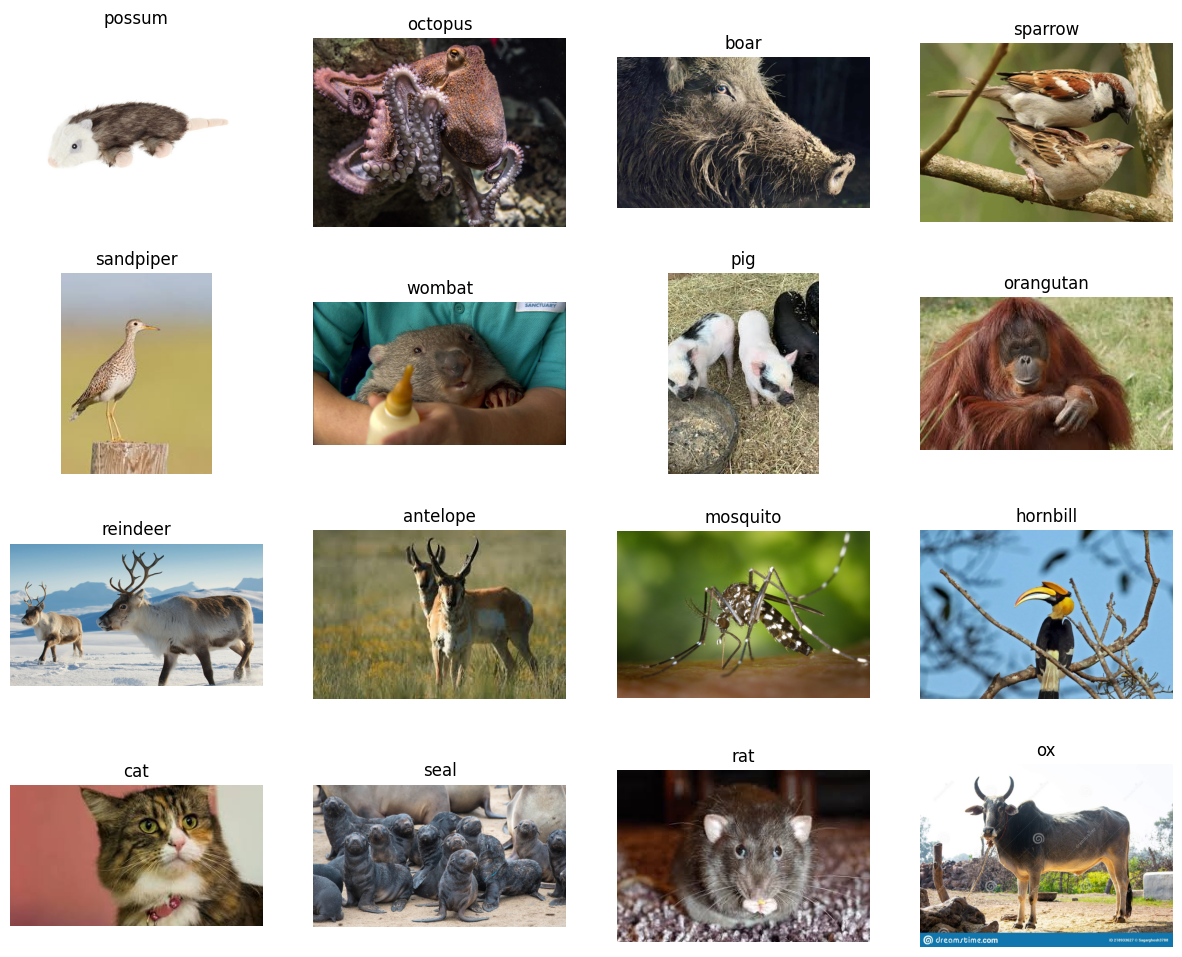

In [20]:
plt.figure(figsize=(15,12))
for i, row in df.sample(n=16).reset_index().iterrows():
  plt.subplot(4, 4, i+1)
  image_path = row["imgpath"]
  image = Image.open(image_path)
  plt.imshow(image)
  plt.title(row["labels"])
  plt.axis("off")
plt.show()

Split the dataset into train and test

In [27]:
# Split into train, valid and test
train_df, temp_df = train_test_split(df, train_size=0.70, shuffle=True, random_state=42)
valid_df, test_df = train_test_split(temp_df, train_size=0.70, shuffle=True, random_state=42)
train_df = train_df.reset_index(drop=True)
valid_df = train_df.reset_index(drop=True)
test_df = train_df.reset_index(drop=True)
train_df

,imgpath,labels,encoded_labels
0,/kaggle/input/animal-image-dataset-90-differen...,hummingbird,39
1,/kaggle/input/animal-image-dataset-90-differen...,pelecaniformes,61
2,/kaggle/input/animal-image-dataset-90-differen...,sheep,75
3,/kaggle/input/animal-image-dataset-90-differen...,pig,63
4,/kaggle/input/animal-image-dataset-90-differen...,wolf,86
...,...,...,...
3774,/kaggle/input/animal-image-dataset-90-differen...,gorilla,31
3775,/kaggle/input/animal-image-dataset-90-differen...,woodpecker,88
3776,/kaggle/input/animal-image-dataset-90-differen...,ox,57
3777,/kaggle/input/animal-image-dataset-90-differen...,seahorse,72


Image augmentation


In [47]:
# Define data augmentation transformations
augmentation_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomRotation(20),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5, interpolation=3),
    transforms.ToTensor(),
])

data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

Create the data loaders

In [75]:
# Define the dataset class - encapsulate in a class allows for memory data efficiency during training
class AnimalDataset(Dataset):
  def __init__(self, df, transform=None):
    self.df = df
    self.transform = transform

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    img_path = self.df.iloc[idx]['imgpath']
    label = self.df.iloc[idx]['encoded_labels']
    img = Image.open(img_path)
    if self.transform:
      img = self.transform(img)
    label = torch.tensor(label)
    return img, label

In [76]:
# Create custom datasets with data augmentation
train_dataset = AnimalDataset(train_df, transform = augmentation_transform)
valid_dataset = AnimalDataset(valid_df, transform = data_transform)
test_dataset = AnimalDataset(test_df, transform = data_transform)

In [77]:
# Create DataLoader instances for training and test
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Model Structure

In [58]:
# Model Class
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
    # Fully connected layer
    self.fc1 = nn.Linear(256 * 28 * 28, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 10)

  def forward(self, X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X,2,2) # 2x2 kernel and stride 2
    # Second Pass
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X,2,2) # 2x2 kernel and stride 2
    # Third Pass
    X = F.relu(self.conv3(X))
    X = F.max_pool2d(X,2,2) # 2x2 kernel and stride 2

    # Re-View to flatten it out
    X = X.view(-1, 256 * 28 * 28)

    # Fully connected layers
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    return F.log_softmax(X, dim=1)

In [60]:
# Create an instance of our model
torch.manual_seed(42)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=200704, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

Training the model

In [61]:
# Loss function optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [79]:
import time
start_time = time.time()

# Create Variable to track things
epochs = 100
train_losses = []
valid_losses = []
test_losses = []
train_correct = []
valid_correct = []
test_correct = []

# For Loop Epochs
for i in range(epochs):
  trn_corr = 0
  vld_corr = 0
  tst_corr = 0

  # Train
  for b, (X_train, y_train) in enumerate(train_loader):
    print(b+1)
    b += 1 # start out batches at 1
    y_pred = model.forward(X_train)
    print(y_pred)
    loss = criterion(y_pred, y_train)

    predicted = torch.max(y_pred.data, 1)[1]
    batch_corr = (predicted == y_train).sum()
    trn_corr += batch_corr

    # Update our parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print out some results
    if b%600 == 0:
      print(f'Epoch: {i} Batch: {b} Loss: {loss.item()}')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Test/Validation
    with torch.no_grad():
      for b, (X_valid, y_valid) in enumerate(valid_loader):
        y_val = model(X_valid)
        predicted = torch.max(y_val.data, 1)[1]
        vld_corr += (predicted == y_valid).sum()

      loss = criterion(y_val, y_valid)
      valid_losses.append(loss)
      test_correct.append(tst_corr)

1
tensor([[-2.2595, -2.3460, -2.2793, -2.2917, -2.3141, -2.2753, -2.3620, -2.3367,
         -2.3179, -2.2498],
        [-2.2598, -2.3485, -2.2764, -2.2931, -2.3120, -2.2783, -2.3581, -2.3386,
         -2.3176, -2.2498],
        [-2.2578, -2.3493, -2.2782, -2.2929, -2.3134, -2.2786, -2.3579, -2.3388,
         -2.3156, -2.2498],
        [-2.2581, -2.3461, -2.2792, -2.2903, -2.3134, -2.2799, -2.3605, -2.3378,
         -2.3190, -2.2481],
        [-2.2579, -2.3469, -2.2827, -2.2902, -2.3142, -2.2789, -2.3596, -2.3370,
         -2.3161, -2.2487],
        [-2.2601, -2.3454, -2.2798, -2.2918, -2.3118, -2.2761, -2.3596, -2.3379,
         -2.3209, -2.2488],
        [-2.2580, -2.3482, -2.2765, -2.2941, -2.3103, -2.2809, -2.3581, -2.3383,
         -2.3173, -2.2504],
        [-2.2565, -2.3457, -2.2789, -2.2932, -2.3128, -2.2806, -2.3580, -2.3379,
         -2.3188, -2.2497],
        [-2.2577, -2.3464, -2.2803, -2.2890, -2.3144, -2.2790, -2.3630, -2.3373,
         -2.3147, -2.2503],
        [-2.2609,

IndexError: Target 25 is out of bounds.